In [1]:
import os
print("当前工作目录：", os.getcwd())
import torch
import torchvision
from torchvision import datasets, transforms
# from CL_task_agnostic.loss_surface import 

当前工作目录： d:\Githubdesktop\github\thesis_code\thesis_code\CL_task_agnostic


Detect loss plateau at 160 step for 1 times: last loss window mean: 0.2690169750663345, last loss window variance: 9.8324303800689e-07
new peak detected at 200 step
Detect loss plateau at 366 step for 2 times: last loss window mean: 0.22391582150518108, last loss window variance: 9.624640687811585e-07
new peak detected at 400 step
Detect loss plateau at 565 step for 3 times: last loss window mean: 0.224016512854047, last loss window variance: 9.56070476553321e-07
count_updates: 3


C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from current font.
  plt.tight_layout()
C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from current font.
  plt.tight_layout()
C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.tight_layout()
C:\Users\wangw\AppData\Local\Temp\ipykernel_22844\1975049231.py:68: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) miss

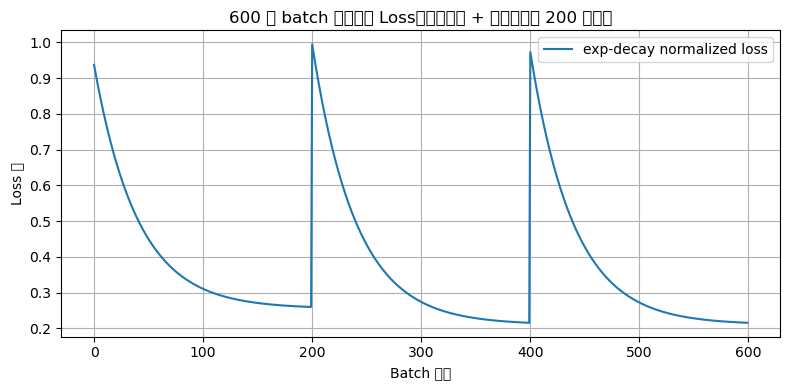

In [8]:
import numpy as np
import matplotlib.pyplot as plt
count_updates=0
loss_window_length = 10
loss_window_mean_threshold = 0.3
loss_window_variance_threshold = 1e-6
loss_window=[]
loss_window_means=[]
loss_window_variances=[]
new_peak_detected = True
# 配置
num_batches = 600
segment_len = 200
k           = 5.0
init_range  = (0.9, 1.0)
final_range = (0.2, 0.3)
seed        = 42

# 1) 随机种子
np.random.seed(seed)

# 2) 每段的起始值和终止值
n_segs     = num_batches // segment_len
init_vals  = np.random.uniform(init_range[0],  init_range[1],  size=n_segs)
final_vals = np.random.uniform(final_range[0], final_range[1], size=n_segs)
# 3) 预计算“指数衰减 + 归一化”曲线
t       = np.arange(segment_len) / (segment_len - 1)   # 线性 t∈[0,1]
raw     = 1.0 - np.exp(-k * t)                         # 指数衰减：0→1
decay_vec = raw / raw[-1]                              # 归一化到 [0,1]
# 4) 循环里实时计算 loss
loss_list = []
for i in range(num_batches):
    seg_idx    = i // segment_len      # 段号 0,1,2
    offset_idx = i % segment_len      # 段内位置 0…segment_len-1
    init_v     = init_vals[seg_idx]
    final_v    = final_vals[seg_idx]
    decay      = decay_vec[offset_idx]
    # 指数衰减 + 归一化 后的线性差值
    loss = init_v - (init_v - final_v) * decay
    loss_list.append(loss)

    loss_window.append(np.mean(loss))
    if len(loss_window)>loss_window_length: del loss_window[0]
    loss_window_mean=np.mean(loss_window)
    loss_window_variance=np.var(loss_window)
    # print(f'batch: {i}loss window mean: {loss_window_mean}, loss window variance: {loss_window_variance}')
    if not new_peak_detected and loss_window_mean > last_loss_window_mean+np.sqrt(last_loss_window_variance) :
        new_peak_detected=True 
        print(f'new peak detected at {i} step')
    
    if loss_window_mean < loss_window_mean_threshold and loss_window_variance < loss_window_variance_threshold and new_peak_detected:
        count_updates+=1
        print(f'Detect loss plateau at {i} step for {count_updates} times: last loss window mean: {loss_window_mean}, last loss window variance: {loss_window_variance}')
        last_loss_window_mean=loss_window_mean
        last_loss_window_variance=loss_window_variance
        new_peak_detected=False
    
print(f'count_updates: {count_updates}')
    

plt.figure(figsize=(8, 4))
plt.plot(loss_list, label="exp-decay normalized loss")
plt.xlabel("Batch 索引")
plt.ylabel("Loss 值")
plt.title("600 个 batch 上的合成 Loss（指数衰减 + 归一化，每 200 一段）")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import pandas as pd

# 1. 指定事件文件路径
# event_file = "./log_CL/99_98_97/seq/epochs=150_seed=44/events.out.tfevents.1744704090.pc3054.3669540.0"
event_file = r"D:\Githubdesktop\github\thesis_code\thesis_code\log_CL_task_agnostic\none\lr=0.001_batch_size=16_batch_number=300_seed=42_num_control_points=(4, 4, 4)_max_displacement=(2, 2, 1)\events.out.tfevents.1747123664.pc3054.966202.0"

# 2. 加载：告诉它 scalars 全都读出来（0 表示不限制数量）
ea = event_accumulator.EventAccumulator(
    event_file,
    size_guidance={event_accumulator.SCALARS: 0}
)
ea.Reload()

# 3. 查看有哪些 scalar tags
print("可用 tags:", ea.Tags()["scalars"])

# 4. 取出 train_loss 对应的所有条目
#    每个 entry 是一个 namedtuple： (wall_time, step, value)
entries = ea.Scalars("train_loss")

# 5. 转成列表 / NumPy /DataFrame
steps      = [e.step for e in entries]
wall_times = [e.wall_time for e in entries]
values     = [e.value for e in entries]

# 作为 Python 列表
loss_list_training = values
print('loss_list len', len(loss_list_training))

# 或转 NumPy 数组
loss_arr = np.array(values)

# Loss_surface detection
count_updates=0
loss_window_length = 10
loss_window_mean_threshold = 0.2
loss_window_variance_threshold = 1e-4
loss_window=[]
loss_window_means=[]
loss_window_variances=[]
new_peak_detected = True
num_batches = len(loss_list_training)
for i in range(num_batches):
    loss = loss_list_training[i]
    loss_window.append(np.mean(loss))
    if len(loss_window)>loss_window_length: del loss_window[0]
    loss_window_mean=np.mean(loss_window)
    loss_window_variance=np.var(loss_window)
    # Save previous loss window mean and variance

    # print(f'batch: {i}loss window mean: {loss_window_mean}, loss window variance: {loss_window_variance} loss winodw length {len(loss_window)}')
    # if not new_peak_detected and loss_window_mean > last_loss_window_mean+np.sqrt(last_loss_window_variance) :
    if not new_peak_detected and loss_window_mean > prev_loss_window_mean+np.sqrt(prev_loss_window_variance) :
        new_peak_detected=True 
        print(f'new peak detected at {i} step')
    
    if loss_window_mean < loss_window_mean_threshold and loss_window_variance < loss_window_variance_threshold and new_peak_detected:
        count_updates+=1
        print(f'Detect loss plateau at {i} step for {count_updates} times: last loss window mean: {loss_window_mean}, last loss window variance: {loss_window_variance}')
        last_loss_window_mean=loss_window_mean
        last_loss_window_variance=loss_window_variance
        new_peak_detected=False
    
    prev_loss_window_mean     = loss_window_mean
    prev_loss_window_variance = loss_window_variance
    
print(f'count_updates: {count_updates}')



# last loss window mean: 0.18679414689540863, last loss window variance: 8.96894832769668e-05

可用 tags: ['learning rate', 'train_loss', 'Testing99', 'Testing98', 'Testing97']
loss_list len 900
Detect loss plateau at 128 step for 1 times: last loss window mean: 0.18426637649536132, last loss window variance: 9.688397136770277e-05
new peak detected at 300 step
Detect loss plateau at 310 step for 2 times: last loss window mean: 0.14859591126441957, last loss window variance: 8.664031221176315e-05
new peak detected at 600 step
Detect loss plateau at 621 step for 3 times: last loss window mean: 0.14123620986938476, last loss window variance: 7.005756060834756e-05
count_updates: 3


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_batch = torch.tensor(0.3, device=device)
print(f'loss_batch: {loss_batch}')
print('loss batch type:', loss_batch.type())
print('loss batch shape:', loss_batch.shape)
loss_value = loss_batch.item()
print('loss value:', loss_value)
print('loss value type:', type(loss_value))

loss_batch: 0.30000001192092896
loss batch type: torch.cuda.FloatTensor
loss batch shape: torch.Size([])
loss value: 0.30000001192092896
loss value type: <class 'float'>
